In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported!")
print("="*60)
print("MODEL MONITORING & MAINTENANCE")
print("="*60)

✓ Libraries imported!
MODEL MONITORING & MAINTENANCE


In [2]:
model = joblib.load('models/final_model.pkl')
df = pd.read_csv('data/processed_data.csv')

X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"\n✓ Model loaded: {type(model).__name__}")
print(f"✓ Data loaded: {df.shape[0]} samples")


✓ Model loaded: XGBClassifier
✓ Data loaded: 7043 samples


In [3]:
# In real scenario, this would be actual new customer data
np.random.seed(42)
sample_size = 500

# Simulate getting new data over time
production_data = X.sample(n=sample_size, random_state=42)
production_labels = y.loc[production_data.index]

# Add timestamps (simulate daily predictions)
dates = pd.date_range(end=datetime.now(), periods=sample_size, freq='D')
production_data['prediction_date'] = dates
production_labels.index = production_data.index

print(f"\n✓ Simulated production data: {sample_size} predictions")
print(f"Date range: {dates.min().date()} to {dates.max().date()}")


✓ Simulated production data: 500 predictions
Date range: 2024-07-23 to 2025-12-04


In [4]:
production_predictions = model.predict(production_data.drop('prediction_date', axis=1))
production_proba = model.predict_proba(production_data.drop('prediction_date', axis=1))[:, 1]

# Create results dataframe
results = pd.DataFrame({
    'date': production_data['prediction_date'],
    'actual': production_labels.values,
    'predicted': production_predictions,
    'probability': production_proba
})

print("\n✓ Predictions generated")
print(results.head())


✓ Predictions generated
                           date  actual  predicted  probability
185  2024-07-23 12:49:55.391441       1          1     0.707967
2715 2024-07-24 12:49:55.391441       0          0     0.094216
3825 2024-07-25 12:49:55.391441       0          0     0.022790
1807 2024-07-26 12:49:55.391441       1          1     0.778252
132  2024-07-27 12:49:55.391441       0          0     0.028258


In [5]:
results['date_only'] = results['date'].dt.date
daily_accuracy = results.groupby('date_only').apply(
    lambda x: accuracy_score(x['actual'], x['predicted'])
).reset_index(name='accuracy')

print("\n" + "="*60)
print("DAILY ACCURACY MONITORING")
print("="*60)
print(f"Mean Accuracy: {daily_accuracy['accuracy'].mean():.4f}")
print(f"Std Deviation: {daily_accuracy['accuracy'].std():.4f}")
print(f"Min Accuracy: {daily_accuracy['accuracy'].min():.4f}")
print(f"Max Accuracy: {daily_accuracy['accuracy'].max():.4f}")


DAILY ACCURACY MONITORING
Mean Accuracy: 0.8260
Std Deviation: 0.3795
Min Accuracy: 0.0000
Max Accuracy: 1.0000



✓ Accuracy trend plot saved


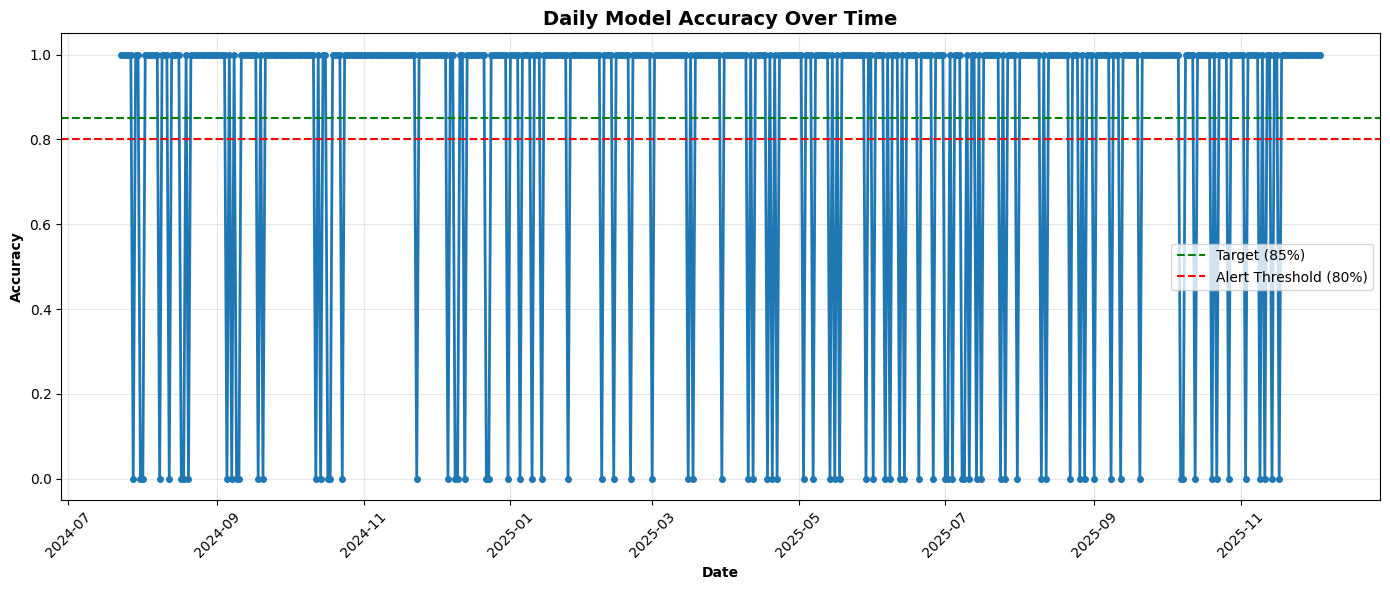

In [6]:
plt.figure(figsize=(14, 6))
plt.plot(daily_accuracy['date_only'], daily_accuracy['accuracy'], 
         marker='o', linewidth=2, markersize=4)
plt.axhline(y=0.85, color='g', linestyle='--', label='Target (85%)')
plt.axhline(y=0.80, color='r', linestyle='--', label='Alert Threshold (80%)')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Daily Model Accuracy Over Time', fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('data/monitoring_accuracy_trend.png')
print("\n✓ Accuracy trend plot saved")
plt.show()

In [7]:
results['week'] = results['date'].dt.to_period('W')

weekly_metrics = results.groupby('week').apply(
    lambda x: pd.Series({
        'accuracy': accuracy_score(x['actual'], x['predicted']),
        'precision': precision_score(x['actual'], x['predicted']),
        'recall': recall_score(x['actual'], x['predicted']),
        'f1_score': f1_score(x['actual'], x['predicted']),
        'samples': len(x)
    })
).reset_index()

print("\n" + "="*60)
print("WEEKLY PERFORMANCE SUMMARY")
print("="*60)
print(weekly_metrics.tail(10).to_string(index=False))



WEEKLY PERFORMANCE SUMMARY
                 week  accuracy  precision   recall  f1_score  samples
2025-09-29/2025-10-05  1.000000   1.000000 1.000000  1.000000      7.0
2025-10-06/2025-10-12  0.714286   1.000000 0.333333  0.500000      7.0
2025-10-13/2025-10-19  0.857143   1.000000 0.500000  0.666667      7.0
2025-10-20/2025-10-26  0.714286   0.500000 1.000000  0.666667      7.0
2025-10-27/2025-11-02  0.857143   0.666667 1.000000  0.800000      7.0
2025-11-03/2025-11-09  0.714286   0.500000 0.500000  0.500000      7.0
2025-11-10/2025-11-16  0.714286   0.666667 0.666667  0.666667      7.0
2025-11-17/2025-11-23  0.857143   1.000000 0.500000  0.666667      7.0
2025-11-24/2025-11-30  1.000000   0.000000 0.000000  0.000000      7.0
2025-12-01/2025-12-07  1.000000   1.000000 1.000000  1.000000      4.0


In [8]:
print("\n" + "="*60)
print("FEATURE DRIFT DETECTION")
print("="*60)

# Compare original training distribution vs production
training_data = X.sample(n=sample_size, random_state=100)
production_features = production_data.drop('prediction_date', axis=1)

# Calculate mean and std for key features
key_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

drift_report = []
for feature in key_features:
    train_mean = training_data[feature].mean()
    prod_mean = production_features[feature].mean()
    train_std = training_data[feature].std()
    
    # Calculate drift (normalized difference)
    drift = abs(prod_mean - train_mean) / train_std
    
    drift_report.append({
        'Feature': feature,
        'Train_Mean': train_mean,
        'Prod_Mean': prod_mean,
        'Drift_Score': drift,
        'Status': '⚠️ DRIFT' if drift > 0.5 else '✅ OK'
    })

drift_df = pd.DataFrame(drift_report)
print(drift_df.to_string(index=False))


FEATURE DRIFT DETECTION
       Feature  Train_Mean  Prod_Mean  Drift_Score Status
        tenure    0.008749  -0.017475     0.025689   ✅ OK
MonthlyCharges    0.047059   0.021304     0.026256   ✅ OK
  TotalCharges   -0.001967  -0.012290     0.010238   ✅ OK



✓ Feature drift visualization saved


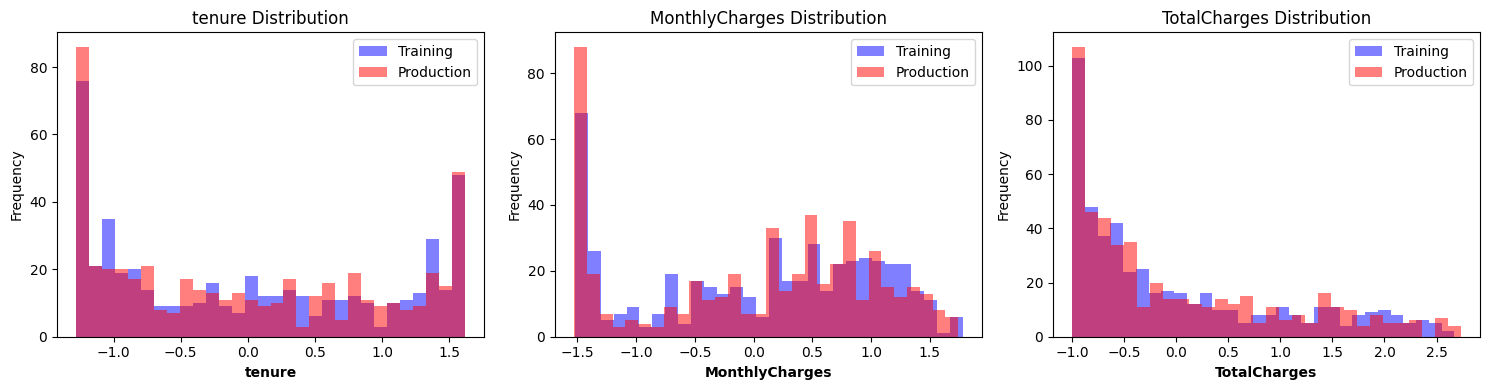

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, feature in enumerate(key_features):
    axes[idx].hist(training_data[feature], bins=30, alpha=0.5, 
                   label='Training', color='blue')
    axes[idx].hist(production_features[feature], bins=30, alpha=0.5, 
                   label='Production', color='red')
    axes[idx].set_xlabel(feature, fontweight='bold')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{feature} Distribution')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('data/monitoring_feature_drift.png')
print("\n✓ Feature drift visualization saved")
plt.show()


In [10]:
print("\n" + "="*60)
print("PREDICTION DISTRIBUTION")
print("="*60)

churn_rate_actual = results['actual'].mean()
churn_rate_predicted = results['predicted'].mean()

print(f"Actual Churn Rate: {churn_rate_actual:.2%}")
print(f"Predicted Churn Rate: {churn_rate_predicted:.2%}")
print(f"Difference: {abs(churn_rate_actual - churn_rate_predicted):.2%}")


PREDICTION DISTRIBUTION
Actual Churn Rate: 28.20%
Predicted Churn Rate: 23.20%
Difference: 5.00%


In [11]:
print("\n" + "="*60)
print("FALSE NEGATIVE ANALYSIS (Missed Churners)")
print("="*60)

false_negatives = results[(results['actual'] == 1) & (results['predicted'] == 0)]
fn_rate = len(false_negatives) / len(results[results['actual'] == 1])

print(f"False Negatives: {len(false_negatives)}")
print(f"False Negative Rate: {fn_rate:.2%}")
print(f"Status: {'⚠️ HIGH' if fn_rate > 0.20 else '✅ OK'}")



FALSE NEGATIVE ANALYSIS (Missed Churners)
False Negatives: 56
False Negative Rate: 39.72%
Status: ⚠️ HIGH


In [12]:
print("\n" + "="*60)
print("ALERT SYSTEM")
print("="*60)

alerts = []

# Check accuracy threshold
current_accuracy = accuracy_score(results['actual'], results['predicted'])
if current_accuracy < 0.80:
    alerts.append("🔴 CRITICAL: Accuracy dropped below 80%!")

# Check false negative rate
if fn_rate > 0.25:
    alerts.append("🟠 WARNING: False negative rate too high!")

# Check feature drift
if any(drift_df['Drift_Score'] > 0.5):
    alerts.append("🟡 NOTICE: Feature drift detected!")

# Check prediction volume
recent_week = results[results['week'] == results['week'].max()]
if len(recent_week) < 10:
    alerts.append("🟡 NOTICE: Low prediction volume!")

if alerts:
    print("\n⚠️ ALERTS DETECTED:")
    for alert in alerts:
        print(f"  {alert}")
else:
    print("\n✅ All systems operational - No alerts")


ALERT SYSTEM

⚠️ ALERTS DETECTED:
  🟠 WARNING: False negative rate too high!
  🟡 NOTICE: Low prediction volume!


In [14]:
print("\n" + "="*60)
print("RETRAINING RECOMMENDATION")
print("="*60)

# Decision logic for retraining
retrain = False
reasons = []

if current_accuracy < 0.82:
    retrain = True
    reasons.append("• Accuracy below threshold")

if fn_rate > 0.22:
    retrain = True
    reasons.append("• High false negative rate")

if any(drift_df['Drift_Score'] > 0.7):
    retrain = True
    reasons.append("• Significant feature drift")

# Time-based (simulate 90 days)
days_since_training = 90
if days_since_training > 90:
    retrain = True
    reasons.append("• 90+ days since last training")

if retrain:
    print("🔄 RECOMMENDATION: Retrain model")
    print("\nReasons:")
    for reason in reasons:
        print(reason)
    print("\nNext steps:")
    print("1. Collect latest data")
    print("2. Re-run feature engineering")
    print("3. Retrain and evaluate model")
    print("4. Compare with current model")
    print("5. Deploy if performance improves")
else:
    print("✅ Model performance is stable")
    print("Continue monitoring, no retraining needed yet")



RETRAINING RECOMMENDATION
🔄 RECOMMENDATION: Retrain model

Reasons:
• High false negative rate

Next steps:
1. Collect latest data
2. Re-run feature engineering
3. Retrain and evaluate model
4. Compare with current model
5. Deploy if performance improves


In [15]:
monitoring_summary = {
    'date': datetime.now(),
    'total_predictions': len(results),
    'accuracy': current_accuracy,
    'precision': precision_score(results['actual'], results['predicted']),
    'recall': recall_score(results['actual'], results['predicted']),
    'f1_score': f1_score(results['actual'], results['predicted']),
    'false_negative_rate': fn_rate,
    'alerts': len(alerts),
    'retrain_recommended': retrain
}

report_df = pd.DataFrame([monitoring_summary])
report_df.to_csv('data/monitoring_report.csv', index=False)
print("\n✓ Monitoring report saved to 'data/monitoring_report.csv'")



✓ Monitoring report saved to 'data/monitoring_report.csv'


In [16]:
print("\n" + "="*60)
print("MONITORING SESSION COMPLETE")
print("="*60)
print(f"Monitoring Period: {dates.min().date()} to {dates.max().date()}")
print(f"Total Predictions: {len(results)}")
print(f"Current Accuracy: {current_accuracy:.2%}")
print(f"Alerts: {len(alerts)}")
print(f"Retrain Needed: {'Yes' if retrain else 'No'}")
print("="*60)


MONITORING SESSION COMPLETE
Monitoring Period: 2024-07-23 to 2025-12-04
Total Predictions: 500
Current Accuracy: 82.60%
Alerts: 2
Retrain Needed: Yes
